### PART I: Probability prediction
- Predict probabilities.
- Look at cross-validated performance and pick your favorite model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,roc_curve
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
warnings.filterwarnings("ignore")



# PART I: Probability prediction

In [2]:
# read in the clean dataset
firms_df = pd.read_csv("https://raw.githubusercontent.com/4mbrus/Data-Analysis-3/refs/heads/main/Assignment%202/bisnode_firms_clean.csv")

In [3]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]

qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]

engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]

engvar3 = []
for col in firms_df.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)

#d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         #"flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"] Data leak! Removed every d1 sales value from the code

hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [4]:
all_vars = rawvars + qualityvars + engvar + engvar2 + engvar3 + hr 

In [5]:
firms_df[all_vars].isna().sum()

curr_assets            0
curr_liab              0
extra_exp              0
extra_inc              0
extra_profit_loss      0
                      ..
flag_miss_ceo_age      0
ceo_count              0
labor_avg_mod          0
flag_miss_labor_avg    0
foreign_management     0
Length: 74, dtype: int64

In [6]:
firms_df.dropna(inplace=True)

### Dealing with categorical variables
To avoide multicolinearity, we drop the first values

In [7]:
firms_df.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
0,2013,1002029.0,2013-01-01,2013-12-31,14255.555664,217103.703125,161174.078125,0.0,0.0,0.0,...,0,0,1,0.437500,0,1.054824,0,0,-1.155013,1.334055
1,2013,1011889.0,2013-01-01,2013-12-31,66125.929688,235114.812500,16555.554688,0.0,0.0,0.0,...,0,0,0,1.583333,0,0.666460,0,0,0.019109,0.000365
2,2013,1014183.0,2013-01-01,2013-12-31,6970.370605,209562.968750,5703.703613,0.0,0.0,0.0,...,0,0,0,0.819444,0,4.632597,0,0,-0.110044,0.012110
3,2013,1022796.0,2013-01-01,2013-12-31,503.703705,3859.259277,8114.814941,0.0,0.0,0.0,...,0,0,0,0.083333,0,9.971799,0,0,0.488146,0.238287
4,2013,1035705.0,2013-01-01,2013-12-31,244.444443,2392.592529,9733.333008,0.0,0.0,0.0,...,0,0,0,0.222222,0,14.500839,0,0,-0.079375,0.006300


In [8]:
firms_df["ind2_cat"].value_counts().sort_index()

ind2_cat
26.0     735
27.0     441
28.0    1389
29.0     179
30.0     104
33.0    1382
55.0    1299
56.0    8039
Name: count, dtype: int64

In [9]:
firms_df["urban_m"].value_counts().sort_index()

urban_m
1.0    4278
2.0    3872
3.0    5418
Name: count, dtype: int64

In [10]:
firms_df["m_region_loc"].value_counts().sort_index()

m_region_loc
Central    7964
East       3404
West       2200
Name: count, dtype: int64

In [11]:
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat, Treatment(reference=26))", firms_df, return_type="dataframe")
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc, Treatment(reference='Central'))", firms_df, return_type="dataframe")
urban_mmat = patsy.dmatrix("0 + C(urban_m, Treatment(reference=1))", firms_df, return_type="dataframe")  

In [12]:
# Define X1
basevars = firms_df[["sales_mil_log", "sales_mil_log_sq", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = firms_df[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([firms_df[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([firms_df[["sales_mil_log", "sales_mil_log_sq"] + engvar ], firm], axis=1)

# Define X4
X4 = pd.concat([firms_df[["sales_mil_log", "sales_mil_log_sq"] + engvar \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

# Define X5

#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", 
                        firms_df, return_type="dataframe")

#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26]') or col.endswith('C(urban_m)[1]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", 
                        firms_df, return_type="dataframe")

X5 = pd.concat([X4, int1mat, int2mat], axis=1)

# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([firms_df[["sales_mil"] + rawvars + hr + qualityvars], firm], axis=1)

### Setting up the train and test set

In [13]:
y = firms_df["is_fast_growing"]
y.mean()

np.float64(0.2318691037735849)

In [14]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    firms_df,          
    y,                 
    test_size=0.2,     
    random_state=42    
)

train_idx = X_train.index
holdout_idx = X_holdout.index

X_train_lasso = logitvars.loc[train_idx]
X_train_rf = rfvars.loc[train_idx]
X_holdout_rf = rfvars.loc[holdout_idx]

### OLS with Cross-Validation for X1:X5

In [15]:
model_specs = {
    "OLS_Model_X1": X1,
    "OLS_Model_X2": X2, 
    "OLS_Model_X3": X3,
    "OLS_Model_X4": X4,
    "OLS_Model_X5": X5
}

results = {name: {
    'rmse_test': [], 'r2_test': [], 'pred_test_mean': [],
    'rmse_train': [], 'r2_train': [], 'pred_train_mean': []
} for name in model_specs}

k = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through each Model 
for model_name, X_data in model_specs.items():
    
    print(f"Running Cross-Validation for: {model_name}")
    
    # Inner Loop: K-Fold Split
    for train_index, test_index in k.split(X_train):
        
        # Select data based on indices and add constant
        X_train_fold = sm.add_constant(X_data.iloc[train_index])
        X_test_fold = sm.add_constant(X_data.iloc[test_index])
        
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]
        
        # Fit OLS
        model = sm.OLS(y_train_fold, X_train_fold).fit()
        
        # Predict
        y_pred_test = model.predict(X_test_fold)
        y_pred_train = model.predict(X_train_fold)
        
        # --- Store Results into the Dictionary ---
        
        # Test Metrics
        results[model_name]['rmse_test'].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_test)))
        results[model_name]['r2_test'].append(r2_score(y_test_fold, y_pred_test))
        results[model_name]['pred_test_mean'].append(np.mean(y_pred_test))
        
        # Train Metrics
        results[model_name]['rmse_train'].append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
        results[model_name]['r2_train'].append(r2_score(y_train_fold, y_pred_train))
        results[model_name]['pred_train_mean'].append(np.mean(y_pred_train))

print("Calculation complete.")

Running Cross-Validation for: OLS_Model_X1
Running Cross-Validation for: OLS_Model_X2
Running Cross-Validation for: OLS_Model_X3
Running Cross-Validation for: OLS_Model_X4
Running Cross-Validation for: OLS_Model_X5
Calculation complete.


In [16]:
summary_rows = []
for name, metrics in results.items():
    summary_rows.append({
        'Model': name,
        'Avg_RMSE_Test': np.mean(metrics['rmse_test']),
        'Avg_R2_Test': np.mean(metrics['r2_test']),
        'Pred_Test_Mean': np.mean(metrics['pred_test_mean']),
        'Avg_RMSE_Train': np.mean(metrics['rmse_train']),
        'Avg_R2_Train': np.mean(metrics['r2_train']),
        'Pred_Train_Mean': np.mean(metrics['pred_train_mean'])

    })

logit_summary_table = pd.DataFrame(summary_rows)
logit_summary_table.round(4)

,Model,Avg_RMSE_Test,Avg_R2_Test,Pred_Test_Mean,Avg_RMSE_Train,Avg_R2_Train,Pred_Train_Mean
0,OLS_Model_X1,0.4182,0.0166,0.2315,0.4176,0.0195,0.2314
1,OLS_Model_X2,0.4059,0.0739,0.2316,0.4049,0.0782,0.2314
2,OLS_Model_X3,0.3893,0.1477,0.2316,0.3877,0.1549,0.2314
3,OLS_Model_X4,0.3902,0.1432,0.2309,0.3825,0.1776,0.2314
4,OLS_Model_X5,0.3891,0.1486,0.2309,0.3791,0.1920,0.2314


Model 5 performs the best.

### Logistic Regression with Cross-Validation for X1:X5

In [17]:
#This takes a while, 4min 35sec for me, but it is necessary for getting the accurate scores

logit_model_vars = {
    "Logit_Model_X1": X1.loc[train_idx],
    "Logit_Model_X2": X2.loc[train_idx],
    "Logit_Model_X3": X3.loc[train_idx],
    "Logit_Model_X4": X4.loc[train_idx],
    "Logit_Model_X5": X5.loc[train_idx]
}

# Initialize storage dictionaries
logit_models = {}
CV_RMSE_folds = {}
logit_accuracy = {}
logit_auc = {}

# Loop through the dictionary
for name, X_data in logit_model_vars.items():
    print(pd.Timestamp.now(), f'Running regression for {name}...')
    
    # Setup the Brier/RMSE Model
    LRCV_brier = LogisticRegressionCV(
        Cs=[1e20],  # No regularization (Standard Logit)
        cv=k, 
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20250224,
        n_jobs=-1  
    )
    
    # Fit & Store RMSE 
    model = LRCV_brier.fit(X_data, y_train)
    logit_models[name] = model
    
    # Extract CV RMSE from the internal storage
    raw_scores = model.scores_[1]
    CV_RMSE_folds[name] = np.sqrt(-1 * raw_scores).flatten()
    
    # Calculate CV Accuracy 
    acc_scores = cross_val_score(model, X_data, y_train, cv=k, scoring='accuracy', n_jobs=-1)
    logit_accuracy[name] = acc_scores.mean() 
    
    # Calculate CV AUC
    auc_scores = cross_val_score(model, X_data, y_train, cv=k, scoring='roc_auc', n_jobs=-1)
    logit_auc[name] = auc_scores.mean()

2026-02-11 09:52:44.768418 Running regression for Logit_Model_X1...


2026-02-11 09:52:48.467873 Running regression for Logit_Model_X2...
2026-02-11 09:52:50.796182 Running regression for Logit_Model_X3...
2026-02-11 09:53:11.751802 Running regression for Logit_Model_X4...
2026-02-11 09:54:15.840891 Running regression for Logit_Model_X5...


In [18]:
table_rows = []

for name in logit_models.keys():
    avg_rmse = np.mean(CV_RMSE_folds[name])
    # Get the score you stored (Note: for LogisticRegression, .score() is Accuracy)
    
    table_rows.append({
        'Model': name,
        'RMSE': avg_rmse,
        'Accuracy': logit_accuracy[name],
        'AUC': logit_auc[name]
    })

# Create the DataFrame
logit_summary_table = pd.DataFrame(table_rows)
logit_summary_table = logit_summary_table.round(4)
logit_summary_table

,Model,RMSE,Accuracy,AUC
0,Logit_Model_X1,0.4180,0.7679,0.5898
1,Logit_Model_X2,0.4034,0.7710,0.6955
2,Logit_Model_X3,0.3861,0.7992,0.7477
3,Logit_Model_X4,0.3837,0.8017,0.7585
4,Logit_Model_X5,0.3823,0.8025,0.7595


In [19]:
best_logit_summary_table = logit_summary_table[logit_summary_table["Model"] == "Logit_Model_X4"] # we prefere model X4 because its simpler than X5 and practically as good

In [20]:
best_logit_summary_table

,Model,RMSE,Accuracy,AUC
3,Logit_Model_X4,0.3837,0.8017,0.7585


The best model is Model 4 and 5 are equaly good, 4 is simpler so we prefer that.

### Lasso Logit

In [21]:
# Define Hyperparameters (Lambdas -> Cs)
lambdas = list(10**np.arange(-1, -4.01, -1/3))
n_obs = len(X_train_lasso) * 4/5 
Cs_values = [1/(l*n_obs) for l in lambdas]

#Create & Fit the RMSE-Optimized Model (Brier Score)
# We use a Pipeline to scale data INSIDE the CV loop (prevents leakage)
lasso_rmse_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegressionCV(
        Cs=Cs_values,
        penalty='l1',
        cv=k,                        
        scoring='neg_brier_score',  
        solver='liblinear',
        random_state=42,
        n_jobs=-1               
    ))
])

print("Running LASSO (Optimizing for RMSE)...")
lasso_rmse_pipe.fit(X_train_lasso, y_train)

# --- EXTRACTING RESULTS ---

model_internal = lasso_rmse_pipe.named_steps['lasso']

# .scores_[1] gives shape (n_folds, n_Cs). Mean across folds.
mean_brier_scores = model_internal.scores_[1].mean(axis=0)

# Find the best score (Max because it's negative brier)
best_brier_idx = np.argmax(mean_brier_scores)
best_brier_score = mean_brier_scores[best_brier_idx]
best_rmse = np.sqrt(-1 * best_brier_score)

# Get the Best Hyperparameters (C and Lambda)
best_C = model_internal.Cs_[best_brier_idx]
best_lambda_val = 1 / (best_C * n_obs)


# Calculate Accuracy an AUC
lasso_winner_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_fixed', LogisticRegression(
        C=best_C,        # <--- The winner from Step 1
        penalty='l1', 
        solver='liblinear', 
        random_state=42
    ))
])

# Run 5-fold CV just for this one best configuration to get accuracy and AUC
acc_scores = cross_val_score(lasso_winner_model, X_train_lasso, y_train, cv=k, scoring='accuracy')
corresponding_accuracy = acc_scores.mean()

auc_scores = cross_val_score(lasso_winner_model, X_train_lasso, y_train, cv=k, scoring='roc_auc')
final_auc = auc_scores.mean()



Running LASSO (Optimizing for RMSE)...


In [22]:
lasso_summary_table = pd.DataFrame([{
    'Model': 'LASSO Logit',
    'Optimized_For': 'RMSE (Brier)',
    'Best_Lambda': best_lambda_val,
    'RMSE': best_rmse,
    'Accuracy': corresponding_accuracy,
    'AUC': final_auc
}])

lasso_summary_table = lasso_summary_table.round(4)
lasso_summary_table_small = lasso_summary_table[["Model", "RMSE", "Accuracy", "AUC"]]
lasso_summary_table

,Model,Optimized_For,Best_Lambda,RMSE,Accuracy,AUC
0,LASSO Logit,RMSE (Brier),0.001,0.3817,0.8029,0.7613


Logit Model 4, 5 and LASSO Logit perform almost the same, lets choose model 4 for simplicity.

In [23]:
#Keep this in the code for demonstration:)

# Access the fitted model step from your pipeline
model_step = lasso_rmse_pipe.named_steps['lasso']

# Extract coefficients
# .coef_ is a list of lists. We grab the first one [0].
coefs = model_internal.coef_[0]

# We use abs() to find the strongest drivers regardless of + or - direction
feature_importance = pd.DataFrame({
    'Feature': X_train_lasso.columns,
    'Coefficient': coefs,
    'Abs_Coef': np.abs(coefs)
})

# Sort by the biggest impact
top_suspects = feature_importance.sort_values(by='Abs_Coef', ascending=False).head(10)

 # Data leak found: d1 values
print(top_suspects)

                               Feature  Coefficient  Abs_Coef
1                     sales_mil_log_sq    -0.724090  0.724090
62                                 new     0.632799  0.632799
60                                 age    -0.478816  0.478816
15                 profit_loss_year_pl     0.461351  0.461351
108              C(ind2_cat)[56.0]:age    -0.333435  0.333435
16                    personnel_exp_pl    -0.285721  0.285721
61                                age2     0.280807  0.280807
159  sales_mil_log:profit_loss_year_pl     0.276504  0.276504
6                          share_eq_bs    -0.239560  0.239560
59                balsheet_notfullyear    -0.227401  0.227401


### Random Forest

In [24]:
# Define Grid & Model
grid = {
    'max_features': [5, 6, 7, "sqrt"],
    'criterion': ['gini'],
    'min_samples_split': [11, 16],
    'n_estimators': [500]
}

prob_forest = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,
    oob_score=True
)

# Run Grid Search
prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=5, 
    refit='neg_brier_score',  
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1
)

print("Running Random Forest Grid Search...")
prob_forest_grid.fit(X_train_rf, y_train)

# --- TABLE 1: DETAILED RESULTS (Every Combination) ---

# Extract results into a DataFrame
cv_results = pd.DataFrame(prob_forest_grid.cv_results_)

# Keep only the columns we care about
cols_to_keep = ['param_max_features', 'param_min_samples_split', 
                'mean_test_accuracy', 'mean_test_roc_auc', 'mean_test_neg_brier_score']
summary_table = cv_results[cols_to_keep].copy()

# Rename columns for readability
summary_table.columns = ['Max_Features', 'Min_Samples_Split', 'Accuracy', 'AUC', 'Neg_Brier']

# Calculate RMSE from Neg_Brier
summary_table['RMSE'] = np.sqrt(-1 * summary_table['Neg_Brier'])

# Drop the confusing 'Neg_Brier' column now that we have RMSE
summary_table = summary_table.drop(columns=['Neg_Brier'])

# Sort by Lowest RMSE (Best Probabilities)
summary_table = summary_table.sort_values(by='RMSE', ascending=True)

print("\n--- Detailed Results (All Combinations) ---")
summary_table.round(4)


Running Random Forest Grid Search...

--- Detailed Results (All Combinations) ---


,Max_Features,Min_Samples_Split,Accuracy,AUC,RMSE
3,6,16,0.8062,0.7747,0.3770
7,sqrt,16,0.8062,0.7747,0.3770
1,5,16,0.8050,0.7745,0.3773
0,5,11,0.8051,0.7735,0.3775
4,7,11,0.8057,0.7735,0.3775
5,7,16,0.8047,0.7730,0.3776
2,6,11,0.8055,0.7727,0.3777
6,sqrt,11,0.8055,0.7727,0.3777


In [25]:
# --- TABLE 2: BEST MODEL SUMMARY ---

best_row = summary_table.iloc[0] # The row with lowest RMSE

best_rf_summary = pd.DataFrame([{
    'Model': 'Random Forest',
    'Optimized_For': 'RMSE (Manual Sort)',
    'Max_Features': best_row['Max_Features'],
    'Min_Samples_Split': best_row['Min_Samples_Split'],
    'RMSE': best_row['RMSE'],
    'Accuracy': best_row['Accuracy'],
    'AUC': best_row['AUC']
}])

print("\n--- Best Random Forest Model Summary ---")
best_rf_summary.round(4)


--- Best Random Forest Model Summary ---


,Model,Optimized_For,Max_Features,Min_Samples_Split,RMSE,Accuracy,AUC
0,Random Forest,RMSE (Manual Sort),6,16,0.377,0.8062,0.7747


### Gradient Boosting

In [26]:
# Setup Data
X_train_gb = X_train_rf # Use the same clean vars as Random Forest

# Define the Hyperparameter Grid
gb_params = {
    'n_estimators': [100, 200, 500],         
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [3, 5],               
}           

# Setup Model
gb_model = GradientBoostingClassifier(random_state=42)

# Run Grid Search with Multiple Metrics
gb_grid = GridSearchCV(
    gb_model, 
    gb_params, 
    cv=5, 
    refit='neg_brier_score',  # Optimize for best PROBABILITY (RMSE)
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1
)

print("Running Gradient Boosting Grid Search...")
gb_grid.fit(X_train_gb, y_train)

# --- TABLE 1: DETAILED RESULTS ---

cv_results_gb = pd.DataFrame(gb_grid.cv_results_)

# Select and rename columns
cols_gb = ['param_learning_rate', 'param_n_estimators', 'param_max_depth', 
           'mean_test_accuracy', 'mean_test_roc_auc', 'mean_test_neg_brier_score']

gb_summary = cv_results_gb[cols_gb].copy()
gb_summary.columns = ['Learning_Rate', 'N_Estimators', 'Max_Depth', 'Accuracy', 'AUC', 'Neg_Brier']

# Calculate RMSE
gb_summary['RMSE'] = np.sqrt(-1 * gb_summary['Neg_Brier'])
gb_summary = gb_summary.drop(columns=['Neg_Brier'])

# Sort by Best RMSE
gb_summary = gb_summary.sort_values(by='RMSE', ascending=True)

print("\n--- Gradient Boosting Results (Top 5) ---")
gb_summary.head(5).round(4)



Running Gradient Boosting Grid Search...



--- Gradient Boosting Results (Top 5) ---


,Learning_Rate,N_Estimators,Max_Depth,Accuracy,AUC,RMSE
1,0.05,200,3,0.8076,0.7811,0.3753
6,0.10,100,3,0.8088,0.7797,0.3754
3,0.05,100,5,0.8060,0.7811,0.3757
4,0.05,200,5,0.8079,0.7805,0.3758
7,0.10,200,3,0.8079,0.7799,0.3758


In [27]:
# --- TABLE 2: BEST MODEL SUMMARY ---

best_row = gb_summary.iloc[0] # The row with lowest RMSE

best_gb_summary = pd.DataFrame([{
    'Model': 'Gradient Boosting',
    'Optimized_For': 'RMSE (Manual Sort)',
    'N_Estimators': best_row['N_Estimators'],
    'Max_Depth': best_row['Max_Depth'],
    'RMSE': best_row['RMSE'],
    'Accuracy': best_row['Accuracy'],
    'AUC': best_row['AUC']
}])

print("\n--- Best Gradient Boosting Model Summary ---")
best_gb_summary.round(4)


--- Best Gradient Boosting Model Summary ---


,Model,Optimized_For,N_Estimators,Max_Depth,RMSE,Accuracy,AUC
0,Gradient Boosting,RMSE (Manual Sort),200.0,3.0,0.3753,0.8076,0.7811


In [28]:
best_gb_summary_small = best_gb_summary[["Model", "RMSE", "Accuracy", "AUC"]].round(4)
best_rf_summary_small = best_rf_summary[["Model", "RMSE", "Accuracy", "AUC"]].round(4)

print("\n--- Full Model Comparison Table ---")
full_comparison_table = pd.concat([best_logit_summary_table, lasso_summary_table_small, best_gb_summary_small, best_rf_summary_small], axis=0)
full_comparison_table



--- Full Model Comparison Table ---


,Model,RMSE,Accuracy,AUC
3,Logit_Model_X4,0.3837,0.8017,0.7585
0,LASSO Logit,0.3817,0.8029,0.7613
0,Gradient Boosting,0.3753,0.8076,0.7811
0,Random Forest,0.3770,0.8062,0.7747


The best probability predictor of fast growth is the gradient boost model, according to all observed metrics.

# PART II: Classification

### Business Scenario: Capital Preservation & Growth Targeting
**Objective**

We are an investment firm looking to invest in several risky, but fast growing companies. Our specific target is to identify high-potential companies capable of "Fast Growth" (defined as >30% ROI per year). We know that on average around 20% of companies hit this growth-rate, and we want to invest around 200 Million USD in total, so 1 Million in each company the model finds fast growing.

**The Challenge**
While we seek high returns, our primary mandate is capital preservation. We operate under a highly asymmetric risk profile where the cost of a bad investment far outweighs the cost of a missed opportunity.

**Risk Dynamics (The "Error" Costs)**

- False Positive (The "Trap"): The model predicts high growth, so we invest $1M. The company fails to perform (stagnates, loses value, or defaults).

    - Impact: Potential loss of principal and liquidity lock-up. This is the critical failure mode we must minimize.

- False Negative (The "Miss"): The model predicts low growth, so we pass. The company actually succeeds.

    - Impact: Opportunity cost only. We retain our $10M principal to invest elsewhere.

**Goal**

Our machine learning model must optimize for this asymmetry: we are willing to accept a higher rate of missed opportunities (FN) in exchange for high confidence that our deployed capital is safe (minimizing FP).

**Loss function**

Loss function (simplified model):

$$Total\ Cost\ (USD) = (FN \times \text{Missed Profit}) + (FP \times \text{Bad Investment Pain})$$

The cost of a False Negative is the cost of missing out on a fast growth (30%) investment, therefore:

$C_{FN} = 300\ 000\ USD$

The cost of a False Positive is the cost of investing in a company that defaults, or almost defaults, let say on average we lose 0.6 million USD.

$C_{FP} = 600\ 000\ USD$

Final loss function:

$$Total\ Cost\ (USD) = (FN \times 300\ 000\ USD) + (FP \times 900\ 000\ USD)$$

### Let's pick our 4 best models

But first lets make a function for calculating the business cost:

In [29]:
# Global costs
COST_FN = 300_000
COST_FP = 600_000

def calculate_business_cost(y_true, y_probs, threshold):
    """
    Calculates cost. Handles both Pandas Series and Numpy Arrays safely.
    """
    # Ensure y_true is a simple numpy array so indices don't mess up the math
    if hasattr(y_true, 'to_numpy'):
        y_true = y_true.to_numpy()
    
    # 2. Create Predictions
    y_pred = (y_probs >= threshold).astype(int)
    
    # 3. Calculate FP and FN manually (Masking)
    # Now that both are numpy arrays, this works purely by position
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    total_loss = (fn * COST_FN) + (fp * COST_FP)
    return total_loss

def best_threshold_finder(y_true, y_train_probs_cv):
    """
    Finds the optimal threshold and returns ROC curve arrays.
    Args:
        y_true: The ACTUAL training labels (y_train)
        y_train_probs_cv: The PREDICTED probabilities from cross-validation
    Returns:
        best_threshold: The threshold that minimized cost
        fpr: Array of False Positive Rates (for plotting)
        tpr: Array of True Positive Rates (for plotting)
    """
    thresholds = np.arange(0.0, 1.0, 0.025)
    
    best_threshold = 0.5 
    min_train_cost = float('inf')

    print(f"{'Threshold':<10} | {'Train Cost (USD)':<20}")
    print("-" * 45)

    # 1. Loop to find the Best Threshold (Business Logic)
    for thresh in thresholds:
        cost = calculate_business_cost(y_true, y_train_probs_cv, thresh)
        
        if cost < min_train_cost:
            min_train_cost = cost
            best_threshold = thresh
            
        print(f"{thresh:.2f}       | ${cost:,.0f}")

    print("-" * 45)
    print(f"✅ OPTIMAL THRESHOLD: {best_threshold:.2f}")

    # 2. Generate the Arrays for the ROC Curve
    # This automatically calculates TPR and FPR at every unique probability score
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_train_probs_cv)

    # 3. Return the threshold AND the arrays
    return best_threshold, fpr, tpr

def cost_summary(model_name, y_true, y_probs, best_threshold): #I specifically asked GEMINI to "emojify" this. It is truly an abomination. I am sorry.
    """
    Prints the final emojified report.
    """
    # Generate predictions based on threshold
    y_pred = (y_probs >= best_threshold).astype(int)
    
    # Extract confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate Statistical Metrics
    accuracy    = (tp + tn) / (tp + tn + fp + fn)
    precision   = tp / (tp + fp + 1e-9)
    recall      = tp / (tp + fn + 1e-9)
    specificity = tn / (tn + fp + 1e-9)
    f1_score    = 2 * (precision * recall) / (precision + recall + 1e-9)

    # Calculate financial cost
    final_cost = calculate_business_cost(y_true, y_probs, best_threshold)

    print("\n" + "🚀" * 30)
    print(f"📊 FINAL BUSINESS REPORT: {model_name}")
    print(f"🎯 Selected Threshold: {best_threshold:.2f}")
    print("🚀" * 30)

    print("\n🔍 --- Statistical Performance ---")
    print(f"✅ Accuracy:    {accuracy:.2%}  (Overall correctness)")
    print(f"💎 Precision:   {precision:.2%}  (When we bet, we win)")
    print(f"🎣 Recall:      {recall:.2%}  (How many winners we caught)")
    print(f"🛡️ Specificity: {specificity:.2%}  (How many losers we dodged)")
    print(f"⚖️ F1-Score:    {f1_score:.4f}")

    print("\n💰 --- Financial Breakdown ---")
    print(f"🥳 Correct Investments (TP): {tp}")
    print(f"😴 Correct Rejections (TN):  {tn}")
    print("-" * 60)
    print(f"💸 Missed Profits (FN):     {fn}  x $3M = ${fn * COST_FN:,.0f}")
    print(f"🔥 Bad Investments (FP):    {fp}  x $9M = ${fp * COST_FP:,.0f}")
    print("=" * 60)
    print(f"📉 TOTAL BUSINESS COST:     ${final_cost:,.0f}")
    
    return final_cost

#### Logit X4

In [30]:
# --- 1. Setup Data for X4 Only ---
# Ensure you are using the correct X4 training data
X_train_x4 = X4.loc[train_idx]

# Setup the Model (It was previously in a loop, so its not accessible)
logit_x4_model = LogisticRegressionCV(
    Cs=[1e20],  
    cv=5, 
    refit=True, 
    scoring='neg_brier_score', 
    solver="newton-cg", 
    tol=1e-7, 
    random_state=20250224,
    n_jobs=-1  
)

print("Fitting Logit X4 Model...")
logit_x4_model.fit(X_train_x4, y_train)

# --- 2. Generate "Clean" Probabilities on TRAIN Data via CV ---
print("Generating out-of-fold predictions on Training Data...")
y_train_probs_cv = cross_val_predict(
    logit_x4_model, 
    X_train_x4, 
    y_train, 
    cv=5, 
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# --- 3. Find the Best Threshold using ONLY Training Data ---
best_threshold_logit_x4,fpr_x4, tpr_x4 = best_threshold_finder(y_train, y_train_probs_cv)

# --- 4. Evaluate FINAL Performance on the Holdout Set ---
X_holdout_x4 = X4.loc[holdout_idx]
y_holdout_probs_logit_x4 = logit_x4_model.predict_proba(X_holdout_x4)[:, 1]

# --- 5. PRINT RESULTS ---
final_test_cost_logit_x4 = cost_summary("Logit X4",y_holdout, y_holdout_probs_logit_x4, best_threshold_logit_x4)

Fitting Logit X4 Model...


Generating out-of-fold predictions on Training Data...
Threshold  | Train Cost (USD)    
---------------------------------------------
0.00       | $5,001,000,000
0.03       | $4,765,500,000
0.05       | $4,485,000,000
0.08       | $4,126,800,000
0.10       | $3,681,000,000
0.12       | $3,213,300,000
0.15       | $2,779,500,000
0.18       | $2,410,500,000
0.20       | $2,064,900,000
0.23       | $1,762,200,000
0.25       | $1,525,800,000
0.28       | $1,317,300,000
0.30       | $1,188,300,000
0.33       | $1,064,700,000
0.35       | $955,800,000
0.38       | $876,300,000
0.40       | $818,700,000
0.43       | $778,200,000
0.45       | $751,800,000
0.48       | $734,700,000
0.50       | $724,500,000
0.53       | $715,800,000
0.55       | $705,000,000
0.58       | $702,300,000
0.60       | $704,400,000
0.62       | $705,000,000
0.65       | $700,200,000
0.68       | $700,200,000
0.70       | $701,700,000
0.73       | $703,800,000
0.75       | $704,700,000
0.78       | $709,500,000
0.80 

#### Lasso Logit

In [31]:
# --- 1. Generate "Clean" Probabilities on TRAIN Data via CV ---
# This gives us the probability for every training point as if it were in a test set
print("Generating out-of-fold predictions on Training Data...")
y_train_probs_cv = cross_val_predict(lasso_winner_model, X_train_lasso, y_train, cv=5, method='predict_proba')[:, 1]

# --- 2. Find the Best Threshold using ONLY Training Data ---
best_threshold_lasso,fpr_lasso, tpr_lasso = best_threshold_finder(y_train,y_train_probs_cv)

# --- 3. Evaluate FINAL Performance on the Holdout Set ---
lasso_winner_model.fit(X_train_lasso, y_train) 
y_holdout_probs_lasso = lasso_winner_model.predict_proba(logitvars.loc[holdout_idx])[:, 1]

# --- 4. PRINT RESULTS ---
final_test_cost_lasso = cost_summary("Lasso Logit", y_holdout, y_holdout_probs_lasso, best_threshold_lasso)

Generating out-of-fold predictions on Training Data...
Threshold  | Train Cost (USD)    
---------------------------------------------
0.00       | $5,001,000,000
0.03       | $4,781,400,000
0.05       | $4,482,300,000
0.08       | $4,111,800,000
0.10       | $3,683,100,000
0.12       | $3,237,000,000
0.15       | $2,811,600,000
0.18       | $2,452,200,000
0.20       | $2,118,000,000
0.23       | $1,807,500,000
0.25       | $1,573,200,000
0.28       | $1,358,100,000
0.30       | $1,214,700,000
0.33       | $1,084,500,000
0.35       | $968,400,000
0.38       | $892,500,000
0.40       | $826,800,000
0.43       | $777,300,000
0.45       | $741,600,000
0.48       | $731,400,000
0.50       | $720,300,000
0.53       | $711,600,000
0.55       | $704,400,000
0.58       | $699,300,000
0.60       | $696,600,000
0.62       | $694,500,000
0.65       | $696,000,000
0.68       | $699,900,000
0.70       | $702,600,000
0.73       | $703,800,000
0.75       | $707,700,000
0.78       | $712,200,000
0.80 

#### Random Forest

In [32]:
# --- 1. Get the Best Model from Grid Search ---
best_rf_model = prob_forest_grid.best_estimator_

# --- 2. Generate "Clean" Probabilities on TRAIN Data via CV ---
print("Generating out-of-fold predictions on Training Data...")
y_train_probs_cv = cross_val_predict(
    best_rf_model, 
    X_train_rf, 
    y_train, 
    cv=5, 
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# --- 3. Find the Best Threshold using ONLY Training Data ---
best_threshold_rf, fpr_rf, tpr_rf = best_threshold_finder(y_train, y_train_probs_cv)

# --- 4. Evaluate FINAL Performance on the Holdout Set ---
y_holdout_probs_rf = best_rf_model.predict_proba(X_holdout_rf)[:, 1]

# --- 5. PRINT RESULTS ---
final_test_cost_rf = cost_summary("Random Forest", y_holdout, y_holdout_probs_rf, best_threshold_rf)

Generating out-of-fold predictions on Training Data...
Threshold  | Train Cost (USD)    
---------------------------------------------
0.00       | $5,001,000,000
0.03       | $4,648,200,000
0.05       | $4,386,600,000
0.08       | $4,119,600,000
0.10       | $3,783,000,000
0.12       | $3,384,300,000
0.15       | $3,011,700,000
0.18       | $2,632,500,000
0.20       | $2,283,300,000
0.23       | $1,954,800,000
0.25       | $1,655,100,000
0.28       | $1,441,500,000
0.30       | $1,240,500,000
0.33       | $1,083,000,000
0.35       | $969,900,000
0.38       | $890,400,000
0.40       | $817,500,000
0.43       | $766,800,000
0.45       | $729,300,000
0.48       | $709,500,000
0.50       | $700,500,000
0.53       | $694,800,000
0.55       | $686,400,000
0.58       | $683,400,000
0.60       | $681,900,000
0.62       | $688,500,000
0.65       | $688,500,000
0.68       | $691,800,000
0.70       | $690,900,000
0.73       | $696,300,000
0.75       | $703,200,000
0.78       | $710,400,000
0.80 

#### Gradient Boosting

In [33]:
best_gb_model = gb_grid.best_estimator_

print(f"Best GB Parameters: {gb_grid.best_params_}")

# --- 2. Generate "Clean" Probabilities on TRAIN Data via CV ---
print("Generating out-of-fold predictions on Training Data...")
y_train_probs_cv = cross_val_predict(
    best_gb_model, 
    X_train_gb, 
    y_train, 
    cv=5, 
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# --- 3. Find the Best Threshold using ONLY Training Data ---
best_threshold_gb, fpr_gb, tpr_gb = best_threshold_finder(y_train, y_train_probs_cv)

# --- 4. Evaluate FINAL Performance on the Holdout Set ---
y_holdout_probs_gb = best_gb_model.predict_proba(X_holdout_rf)[:, 1]

# --- 5. PRINT RESULTS ---
final_test_cost_gb = cost_summary("Gradient Boosting", y_holdout, y_holdout_probs_gb, best_threshold_gb)

Best GB Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Generating out-of-fold predictions on Training Data...


Threshold  | Train Cost (USD)    
---------------------------------------------
0.00       | $5,001,000,000
0.03       | $4,671,900,000
0.05       | $4,346,400,000
0.08       | $4,154,700,000
0.10       | $3,787,500,000
0.12       | $3,255,900,000
0.15       | $2,738,400,000
0.18       | $2,301,600,000
0.20       | $1,938,300,000
0.23       | $1,640,100,000
0.25       | $1,425,000,000
0.28       | $1,239,000,000
0.30       | $1,098,600,000
0.33       | $986,400,000
0.35       | $919,500,000
0.38       | $860,100,000
0.40       | $819,300,000
0.43       | $765,000,000
0.45       | $741,300,000
0.48       | $724,200,000
0.50       | $710,400,000
0.53       | $693,600,000
0.55       | $693,000,000
0.58       | $690,600,000
0.60       | $690,600,000
0.62       | $688,800,000
0.65       | $688,800,000
0.68       | $685,200,000
0.70       | $685,500,000
0.73       | $693,000,000
0.75       | $699,300,000
0.78       | $706,500,000
0.80       | $715,500,000
0.83       | $727,800,000
0.85      

#### Model comparison

In [34]:
best_logit_summary_table.iloc[0, 3]

np.float64(0.7585)

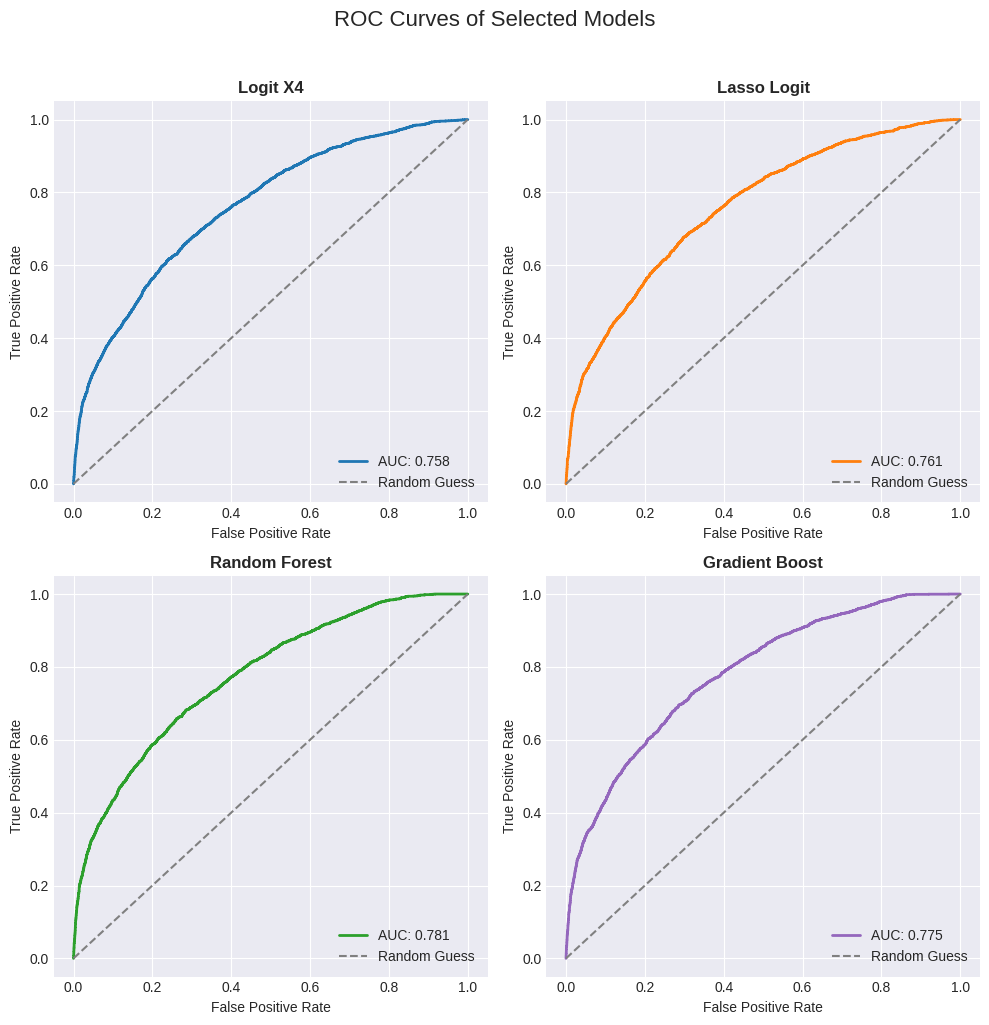

In [35]:
import matplotlib.pyplot as plt

# 1. APPLY THEME (Run this before creating the figure)
plt.style.use('seaborn-v0_8-darkgrid') 
# Other popular options: 'ggplot', 'fivethirtyeight', 'bmh'

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# --- Plot 1: Logit X4 ---
axs[0,0].plot(fpr_x4, tpr_x4, label=f"AUC: {full_comparison_table.iloc[0, 3]:.3f}", color='tab:blue', linewidth=2)
axs[0,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
axs[0,0].set_title("Logit X4", fontsize=12, fontweight='bold')
axs[0,0].set_xlabel('False Positive Rate')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,0].legend(loc='lower right')

# --- Plot 2: Lasso Logit ---
axs[0,1].plot(fpr_lasso, tpr_lasso, label=f"AUC: {full_comparison_table.iloc[1, 3]:.3f}", color='tab:orange', linewidth=2)
axs[0,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
axs[0,1].set_title("Lasso Logit", fontsize=12, fontweight='bold')
axs[0,1].set_xlabel('False Positive Rate')
axs[0,1].set_ylabel('True Positive Rate')
axs[0,1].legend(loc='lower right')

# --- Plot 3: Random Forest ---
axs[1,0].plot(fpr_rf, tpr_rf, label=f"AUC: {full_comparison_table.iloc[2, 3]:.3f}", color='tab:green', linewidth=2)
axs[1,0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
axs[1,0].set_title("Random Forest", fontsize=12, fontweight='bold')
axs[1,0].set_xlabel('False Positive Rate')
axs[1,0].set_ylabel('True Positive Rate')
axs[1,0].legend(loc='lower right')

# --- Plot 4: Gradient Boost ---
axs[1,1].plot(fpr_gb, tpr_gb, label=f"AUC: {full_comparison_table.iloc[3, 3]:.3f}", color='tab:purple', linewidth=2)
axs[1,1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
axs[1,1].set_title("Gradient Boost", fontsize=12, fontweight='bold')
axs[1,1].set_xlabel('False Positive Rate')
axs[1,1].set_ylabel('True Positive Rate')
axs[1,1].legend(loc='lower right')

# 2. FINAL ADJUSTMENTS
fig.suptitle("ROC Curves of Selected Models", fontsize=16, y=1.02)
plt.tight_layout() 
plt.show()

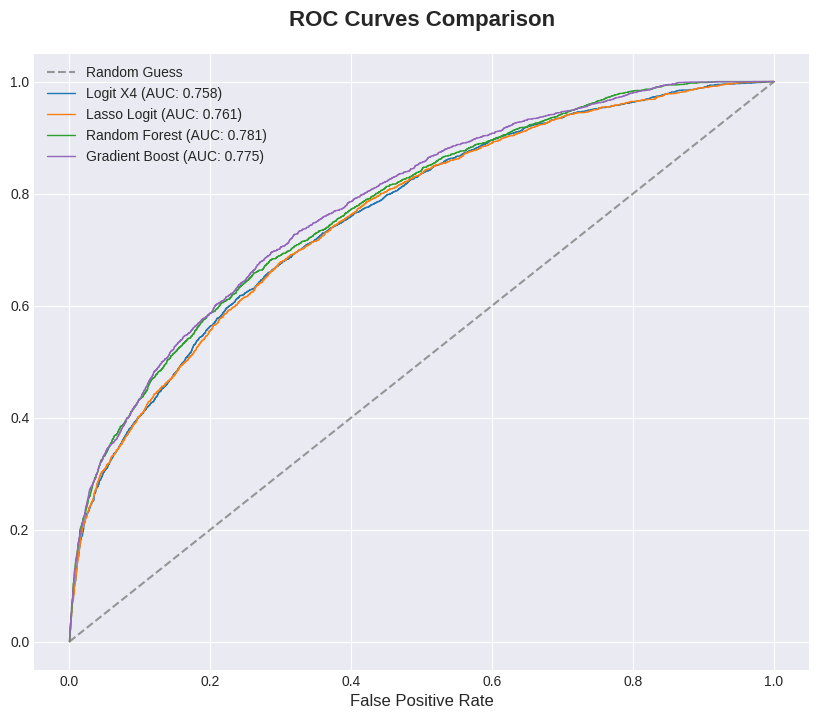

In [36]:
plt.style.use('seaborn-v0_8-darkgrid') 

# 2. SETUP SINGLE PLOT
plt.figure(figsize=(10, 8))

# --- Plot Baseline (Random Guess) First ---
# Plotting this first ensures it stays in the background
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess', alpha=0.8)

# --- Plot 1: Logit X4 ---
plt.plot(fpr_x4, tpr_x4, 
         label=f"Logit X4 (AUC: {full_comparison_table.iloc[0, 3]:.3f})", 
         color='tab:blue', linewidth=1)

# --- Plot 2: Lasso Logit ---
plt.plot(fpr_lasso, tpr_lasso, 
         label=f"Lasso Logit (AUC: {full_comparison_table.iloc[1, 3]:.3f})", 
         color='tab:orange', linewidth=1)

# --- Plot 3: Random Forest ---
plt.plot(fpr_rf, tpr_rf, 
         label=f"Random Forest (AUC: {full_comparison_table.iloc[2, 3]:.3f})", 
         color='tab:green', linewidth=1)

# --- Plot 4: Gradient Boost ---
plt.plot(fpr_gb, tpr_gb, 
         label=f"Gradient Boost (AUC: {full_comparison_table.iloc[3, 3]:.3f})", 
         color='tab:purple', linewidth=1)

# 3. LABELS AND LEGEND
plt.title("ROC Curves Comparison", fontsize=16, fontweight='bold', pad=20)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel
plt.legend()

In [37]:
loss_comparison_df = pd.DataFrame(data={"Model": ["Logit X4", "Lasso Logit", "Random Forest", "Gradient Boosting"],
                                        "Choosen treshhold": [best_threshold_logit_x4, best_threshold_lasso, best_threshold_rf, best_threshold_gb],
                                        "Expected loss (USD)": [final_test_cost_logit_x4, final_test_cost_lasso, final_test_cost_rf, final_test_cost_gb]})

loss_comparison_df["Choosen treshhold"] = loss_comparison_df["Choosen treshhold"].apply(lambda x: f"{x:,.3f}")
loss_comparison_df["Expected loss (USD)"] = loss_comparison_df["Expected loss (USD)"].apply(lambda x: f"{x:,.0f}")

loss_comparison_df

,Model,Choosen treshhold,Expected loss (USD)
0,Logit X4,0.650,"175,500,000"
1,Lasso Logit,0.625,"176,700,000"
2,Random Forest,0.600,"172,500,000"
3,Gradient Boosting,0.675,"174,300,000"


### PART III.

Based on the threshold optimization, the Random Forest classifier achieved the lowest total cost ($172,500,000) using a classification threshold of 0.60.

In [38]:
cost_summary("Random Forest", y_holdout, y_holdout_probs_rf, best_threshold_rf)


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
📊 FINAL BUSINESS REPORT: Random Forest
🎯 Selected Threshold: 0.60
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🔍 --- Statistical Performance ---
✅ Accuracy:    80.32%  (Overall correctness)
💎 Precision:   76.57%  (When we bet, we win)
🎣 Recall:      21.37%  (How many winners we caught)
🛡️ Specificity: 98.04%  (How many losers we dodged)
⚖️ F1-Score:    0.3342

💰 --- Financial Breakdown ---
🥳 Correct Investments (TP): 134
😴 Correct Rejections (TN):  2046
------------------------------------------------------------
💸 Missed Profits (FN):     493  x $3M = $147,900,000
🔥 Bad Investments (FP):    41  x $9M = $24,600,000
📉 TOTAL BUSINESS COST:     $172,500,000


np.int64(172500000)

The model's performance must be evaluated through the lens of capital preservation and the asymmetric cost of errors.

Financial Impact Analysis
- The "Trap" (False Positives): The model identifies 175 companies for investment. Out of these, 41 were "traps" (False Positives). This results in a Precision of 76.5%. From a capital preservation standpoint, this means roughly 3 out of every 4 dollars invested are hitting the "Fast Growth" target, while the remaining dollar faces the $900,000 "Bad Investment Pain."

- The "Miss" (False Negatives): The model is highly conservative, missing 493 high-growth opportunities. While the cumulative "Missed Profit" is high ($147.9M), this aligns with the business mandate to prioritize safety over volume.


- Risk Mitigation: It effectively filters out over 98% of the "Other/Default" companies (2,046 out of 2,087). For an investment firm focused on capital preservation, this high Specificity is the most valuable trait.

- Deployment Strategy: The model recommends 175 investments. Since the firm's goal was to invest around $200M ($1M each in ~200 companies), this model provides a curated list that is close to the target volume while maintaining a high safety margin.

- Strategic Value: Even though we miss many opportunities (low Recall), the 134 "Hits" represent $134M in capital deployed into high-growth assets with a relatively low "Bad Investment" rate.

## Task 2

Let's keep the loss function the same for the sake of simplicity and use our best RF model.

In [39]:
X_holdout_rf["manuf"] = X_holdout_rf[["C(ind2_cat, Treatment(reference=26))[26.0]",
            "C(ind2_cat, Treatment(reference=26))[27.0]",
            "C(ind2_cat, Treatment(reference=26))[28.0]",
            "C(ind2_cat, Treatment(reference=26))[29.0]",
            "C(ind2_cat, Treatment(reference=26))[30.0]",
            "C(ind2_cat, Treatment(reference=26))[33.0]"]].max(axis=1)

X_holdout_rf["service"] = X_holdout_rf[["C(ind2_cat, Treatment(reference=26))[55.0]",
                                    "C(ind2_cat, Treatment(reference=26))[56.0]"]].max(axis=1)

# Use the holdout sets to evaluate performance

X_holdout_manuf = X_holdout_rf[X_holdout_rf["manuf"] == 1]
X_holdout_service = X_holdout_rf[X_holdout_rf["service"] == 1]

print(X_holdout_manuf.shape)
print(X_holdout_service.shape)

y_holdout_manuf = y_holdout.loc[X_holdout_manuf.index]
y_holdout_service = y_holdout.loc[X_holdout_service.index]

#we have to dropp the new columns to use the new models
X_holdout_manuf.drop(columns=["manuf", "service"], inplace=True)
X_holdout_service.drop(columns=["manuf", "service"], inplace=True)

print(X_holdout_manuf.shape)
print(X_holdout_service.shape)


(840, 48)
(1874, 48)
(840, 46)
(1874, 46)


In [40]:
# --- 4. Evaluate FINAL Performance on the Holdout Set ---
y_holdout_probs_manuf = best_rf_model.predict_proba(X_holdout_manuf)[:, 1]

# --- 5. PRINT RESULTS ---
final_test_cost_rf = cost_summary("Random Forest: Manufacturing", y_holdout_manuf, y_holdout_probs_manuf, best_threshold_rf)


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
📊 FINAL BUSINESS REPORT: Random Forest: Manufacturing
🎯 Selected Threshold: 0.60
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🔍 --- Statistical Performance ---
✅ Accuracy:    80.12%  (Overall correctness)
💎 Precision:   76.92%  (When we bet, we win)
🎣 Recall:      11.05%  (How many winners we caught)
🛡️ Specificity: 99.09%  (How many losers we dodged)
⚖️ F1-Score:    0.1932

💰 --- Financial Breakdown ---
🥳 Correct Investments (TP): 20
😴 Correct Rejections (TN):  653
------------------------------------------------------------
💸 Missed Profits (FN):     161  x $3M = $48,300,000
🔥 Bad Investments (FP):    6  x $9M = $3,600,000
📉 TOTAL BUSINESS COST:     $51,900,000


In [41]:
# --- Evaluate FINAL Performance on the Holdout Set ---
y_holdout_probs_service = best_rf_model.predict_proba(X_holdout_service)[:, 1]

# --- PRINT RESULTS ---
final_test_cost_rf = cost_summary("Random Forest: Services", y_holdout_service, y_holdout_probs_service, best_threshold_rf)


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
📊 FINAL BUSINESS REPORT: Random Forest: Services
🎯 Selected Threshold: 0.60
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🔍 --- Statistical Performance ---
✅ Accuracy:    80.42%  (Overall correctness)
💎 Precision:   76.51%  (When we bet, we win)
🎣 Recall:      25.56%  (How many winners we caught)
🛡️ Specificity: 97.55%  (How many losers we dodged)
⚖️ F1-Score:    0.3832

💰 --- Financial Breakdown ---
🥳 Correct Investments (TP): 114
😴 Correct Rejections (TN):  1393
------------------------------------------------------------
💸 Missed Profits (FN):     332  x $3M = $99,600,000
🔥 Bad Investments (FP):    35  x $9M = $21,000,000
📉 TOTAL BUSINESS COST:     $120,600,000


The statistical performance on the two subsets is quite similar to the full holdout set, but there is one significant difference: the model seems to be much better in catching fast growing firms in the services sector (25.5% recall) than in manufacturing (11% recall). This could be due to the fact that there was more training data from services, so the model was able to make more confident prediction about the growth of service sector companies.